<a href="https://colab.research.google.com/github/ahmedhesham47/Bayesian-Network-for-Predicting-ICB-Response/blob/main/Bayes_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pgmpy

# **Importing Packages**

In [75]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, PC, ExhaustiveSearch, BDsScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import K2Score
from pgmpy.inference import VariableElimination, BeliefPropagation, CausalInference, Mplp
import random
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import f1_score
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
import numpy as np
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score
from networkx.algorithms.approximation import clique
from networkx.algorithms.clique import enumerate_all_cliques
from networkx import find_cliques
from sklearn.model_selection import train_test_split, KFold

# **Loading files**

In [4]:
mrna_cont = pd.read_csv('mrna_cont.tsv', sep='\t')
best_e_genes = pd.read_csv('Best Expression Genes.tsv', sep='\t')
labels_df = pd.read_csv('labels_df.tsv',sep='\t')
eigen_genes = pd.read_csv('hartmink_cat_eigengenes.tsv', sep='\t')

# **Data pre-processing**

In [6]:
samples = mrna_cont['Sample Identifier']
mrna_cont.set_index(samples, inplace=True)
best_e_genes_list = best_e_genes['Gene_Name']

reduced_df = mrna_cont[best_e_genes_list]
reduced_df = reduced_df.reset_index()

reduced_df_with_labels = pd.merge(reduced_df, labels_df, on='Sample Identifier')

In [46]:
edges_to_exclude = []
for col in eigen_genes.iloc[:, 1:].columns:
  edges_to_exclude.append(('ICB Response', col))

In [178]:
def split(df, test_size=0.2):
  train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
  return train_df, test_df

# **Discretizing the dataframe**

## **Using mean and standard deviation**

In [8]:
means = reduced_df_with_labels.iloc[:, 1:-1].mean()
std_devs = reduced_df_with_labels.iloc[:, 1:-1].std()

def categorize_value(x, gene, std_unit=1):
    if x < means[gene] - (std_unit*std_devs[gene]):
        return -1
    elif x > means[gene] + (std_unit*std_devs[gene]):
        return 1
    else:
        return 0

std_categorized_df = reduced_df_with_labels.iloc[:, 1:-1].apply(lambda x: x.apply(lambda y: categorize_value(y, x.name)))
std_categorized_df.set_index(samples, inplace=True)
std_categorized_df_with_labels = pd.merge(std_categorized_df, labels_df, on='Sample Identifier')

## **Using Min-Max scaling followed by grouping into n categories**

In [9]:
df = reduced_df_with_labels.iloc[:, 1:-1]
scaled_df = (df - df.min()) / (df.max() - df.min())

def classify_into_groups(value):
    if value == 1:
        return 10
    else:
        return int(value // 0.1) + 1

min_max_categorized_df = scaled_df.applymap(classify_into_groups)
min_max_categorized_df = min_max_categorized_df.apply(lambda x: x.astype('category'))
min_max_categorized_df.set_index(samples, inplace=True)
min_max_categorized_df_with_labels = pd.merge(min_max_categorized_df, labels_df, on='Sample Identifier')

# **Bayesian Network (std discretization)**

In [201]:
bic_score = BicScore(std_categorized_df_with_labels.iloc[:,1:])
K2C_score = K2Score(std_categorized_df_with_labels.iloc[:,1:])
BDs_score = BDsScore(std_categorized_df_with_labels.iloc[:,1:])

hc = HillClimbSearch(std_categorized_df_with_labels.iloc[:,1:])

best_model = hc.estimate(scoring_method=bic_score, max_iter=1000, black_list=edges_to_exclude)
best_model2 = hc.estimate(scoring_method=K2C_score, max_iter=20, black_list=edges_to_exclude)
best_model3 = hc.estimate(scoring_method=BDs_score, max_iter=1000, black_list=edges_to_exclude)

model = BayesianNetwork(best_model.edges())
model2 = BayesianNetwork(best_model2.edges())
model3 = BayesianNetwork(best_model3.edges())

train_df = split(std_categorized_df_with_labels)[0]
test_df = split(std_categorized_df_with_labels)[1]

model.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)
model2.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)
model3.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# **Bayesian Network (min-max discretization)**

In [12]:
# Create an instance of BicScore with the DataFrame
bic_score = BicScore(min_max_categorized_df_with_labels.iloc[:,1:])
K2C_score = K2Score(min_max_categorized_df_with_labels.iloc[:,1:])
BDs_score = BDsScore(min_max_categorized_df_with_labels.iloc[:,1:])

# Initialize HillClimbSearch with the DataFrame
hc = HillClimbSearch(min_max_categorized_df_with_labels.iloc[:,1:])

# Estimate the best model using scoring methods
best_model = hc.estimate(scoring_method=bic_score, max_iter=1000, black_list=edges_to_exclude)
best_model2 = hc.estimate(scoring_method=K2C_score, max_iter=20, black_list=edges_to_exclude)
best_model3 = hc.estimate(scoring_method=BDs_score, max_iter=1000, black_list=edges_to_exclude)

# Learning CPDs (Conditional Probability Distributions)
model = BayesianNetwork(best_model.edges())
model2 = BayesianNetwork(best_model2.edges())
model3 = BayesianNetwork(best_model3.edges())

train_df = split(min_max_categorized_df_with_labels)[0]
test_df = split(min_max_categorized_df_with_labels)[1]

model.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)
model2.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)
model3.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# **Bayesian Network (eigen-genes Hartemink Discretization)**

In [210]:
# Create an instance of BicScore with the DataFrame
bic_score = BicScore(eigen_genes.iloc[:,1:])
K2C_score = K2Score(eigen_genes.iloc[:,1:])
BDs_score = BDsScore(eigen_genes.iloc[:,1:])

# Initialize HillClimbSearch with the DataFrame
hc = HillClimbSearch(eigen_genes.iloc[:,1:])

# Estimate the best model using scoring methods
best_model = hc.estimate(scoring_method=bic_score, max_iter=1000, black_list=edges_to_exclude)
best_model2 = hc.estimate(scoring_method=K2C_score, max_iter=20, black_list=edges_to_exclude)
best_model3 = hc.estimate(scoring_method=BDs_score, max_iter=1000, black_list=edges_to_exclude)

# Learning CPDs (Conditional Probability Distributions)
model = BayesianNetwork(best_model.edges())
model2 = BayesianNetwork(best_model2.edges())
model3 = BayesianNetwork(best_model3.edges())

train_df = split(eigen_genes)[0]
test_df = split(eigen_genes)[1]

model.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)
model2.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)
model3.fit(train_df.iloc[:, 1:], estimator=BayesianEstimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# **Testing the model**

In [211]:
# Create an inference object
inference = VariableElimination(model3)

In [213]:
model_nodes = list(model.nodes)
model3_nodes = list(model3.nodes)
model2_nodes = list(model2.nodes)

model_data = eigen_genes.iloc[:,1:][model_nodes]
model3_data = eigen_genes.iloc[:,1:][model3_nodes]
model2_data = eigen_genes.iloc[:,1:][model2_nodes]

In [214]:
correlation_score(model3, model3_data, test="chi_square", significance_level=0.05)
log_likelihood_score(model3, model3_data)
structure_score(model3, model3_data, scoring_method="bds")

-3020.504223314404

In [215]:
samples = test_df[['Sample Identifier', 'ICB Response']]
sample_ids = list(samples['Sample Identifier'])

In [ ]:
list_of_dicts = test_df.iloc[:,1:-1].to_dict(orient='records')
predictions = {}
for sample_dict, s in zip(list_of_dicts, sample_ids):
  filtered_dict = {key: sample_dict[key] for key in model3_nodes if key in sample_dict}
  query_result = inference.map_query(variables=['ICB Response'], evidence=filtered_dict)
  predictions[s] = query_result['ICB Response']

In [ ]:
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['ICB Response'])
predictions_df.reset_index(inplace=True)
predictions_df.columns = ['Sample Identifier', 'ICB Response']

samples.reset_index(inplace=True)
samples.drop('index', axis=1, inplace=True)

In [218]:
((predictions_df == samples).sum() / len(samples)) * 100

Sample Identifier    100.0
ICB Response          62.5
dtype: float64

# **Network Visualization**

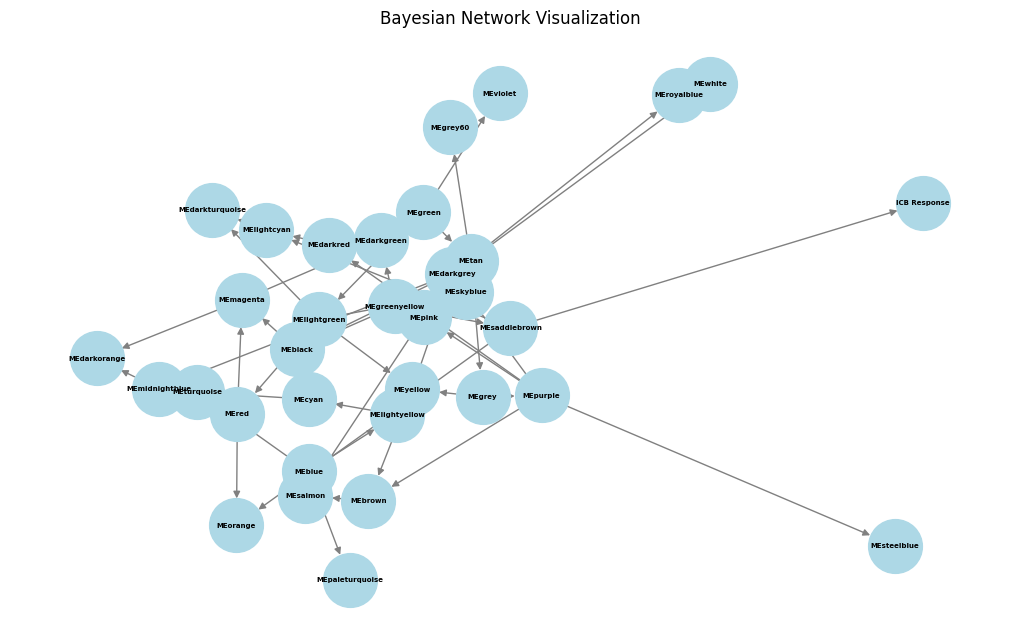

In [219]:
# Create a NetworkX graph from the Bayesian network
G = nx.DiGraph()
G.add_edges_from(best_model3.edges())

# Draw the graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
pos = nx.spring_layout(G)  # Layout for the nodes

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="lightblue", font_size=5, font_weight="bold", edge_color="gray")

# Display the graph
plt.title("Bayesian Network Visualization")
plt.savefig('Bayes_network.png')
plt.show()

In [74]:
edges_list = [edge for edge in best_model3.edges()]
edges_df = pd.DataFrame(edges_list, columns=['Feature 1', 'Feature 2'])
edges_df.to_csv('eigen_gene_interactions.tsv', sep='\t', index=False)

# **Quantifying the strength of edges**

In [ ]:
# Initialize a list to store edge data
edge_data = []

# Iterate over each edge
for parent, child in best_model.edges:
    # Get the CPT for the child node
    cpt = model.get_cpds(node=child)

    # Calculate a measure of influence, e.g., range of probabilities
    influence_measure = cpt.values.ptp()  # Example: peak-to-peak (max-min) of the probabilities

    # Append to the edge data
    edge_data.append((parent, child, influence_measure))

# Convert to DataFrame
edges_df = pd.DataFrame(edge_data, columns=['Gene 1', 'Gene 2', 'Association Strength'])

edges_df.to_csv('gene_interactions_strength_quantified.tsv', sep='\t', index=False)

# **Learning**